In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')

In [6]:
# 1. Load and Transform Data (Same as Notebook 1)
df = pd.read_csv('../data/raw/M2SL.csv')
df['observation_date'] = pd.to_datetime(df['observation_date'])
df.set_index('observation_date', inplace=True)
df.rename(columns={'M2SL': 'M2'}, inplace=True)

# Create Growth Rate
df['M2_Growth'] = np.log(df['M2']).diff() * 100
df_clean = df.dropna()

# 2. Split Train/Test (80/20)
n_obs = len(df_clean)
n_test = int(n_obs * 0.2)
n_train = n_obs - n_test

train = df_clean.iloc[:n_train]
test = df_clean.iloc[n_train:]

print(f"Data Loaded. Train size: {len(train)}, Test size: {len(test)}")

Data Loaded. Train size: 641, Test size: 160


In [7]:
# Define range for p and q
p_values = range(0, 5)
q_values = range(0, 5)
best_aic = float("inf")
best_order = None
best_model = None

print("Starting Grid Search for ARIMA(p,0,q)...")
print("-" * 40)

for p in p_values:
    for q in q_values:
        try:
            # We use d=0 because data is already stationary (Growth Rate)
            # If we used raw data, we would use d=1
            model = ARIMA(train['M2_Growth'], order=(p, 0, q))
            results = model.fit()
            
            # Save the model if it has lower AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, 0, q)
                best_model = results
                
            print(f'ARIMA{p,0,q} - AIC:{results.aic:.2f}')
            
        except:
            continue

print("-" * 40)
print(f"BEST MODEL FOUND: ARIMA{best_order} with AIC: {best_aic:.2f}")

Starting Grid Search for ARIMA(p,0,q)...
----------------------------------------
ARIMA(0, 0, 0) - AIC:494.91
ARIMA(0, 0, 1) - AIC:303.25
ARIMA(0, 0, 2) - AIC:285.53
ARIMA(0, 0, 3) - AIC:225.70
ARIMA(0, 0, 4) - AIC:225.62
ARIMA(1, 0, 0) - AIC:232.69
ARIMA(1, 0, 1) - AIC:214.34
ARIMA(1, 0, 2) - AIC:206.90
ARIMA(1, 0, 3) - AIC:208.17
ARIMA(1, 0, 4) - AIC:192.61
ARIMA(2, 0, 0) - AIC:222.49
ARIMA(2, 0, 1) - AIC:206.30
ARIMA(2, 0, 2) - AIC:202.37
ARIMA(2, 0, 3) - AIC:204.37
ARIMA(2, 0, 4) - AIC:193.69
ARIMA(3, 0, 0) - AIC:207.67
ARIMA(3, 0, 1) - AIC:200.62
ARIMA(3, 0, 2) - AIC:198.60
ARIMA(3, 0, 3) - AIC:195.97
ARIMA(3, 0, 4) - AIC:186.53
ARIMA(4, 0, 0) - AIC:206.20
ARIMA(4, 0, 1) - AIC:202.33
ARIMA(4, 0, 2) - AIC:198.88
ARIMA(4, 0, 3) - AIC:182.84
ARIMA(4, 0, 4) - AIC:185.09
----------------------------------------
BEST MODEL FOUND: ARIMA(4, 0, 3) with AIC: 182.84


                               SARIMAX Results                                
Dep. Variable:              M2_Growth   No. Observations:                  641
Model:                 ARIMA(4, 0, 3)   Log Likelihood                 -82.418
Date:                Fri, 05 Dec 2025   AIC                            182.836
Time:                        16:12:55   BIC                            223.003
Sample:                    02-01-1959   HQIC                           198.426
                         - 06-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5517      0.073      7.562      0.000       0.409       0.695
ar.L1          0.3489      0.076      4.603      0.000       0.200       0.497
ar.L2          0.1975      0.041      4.838      0.0

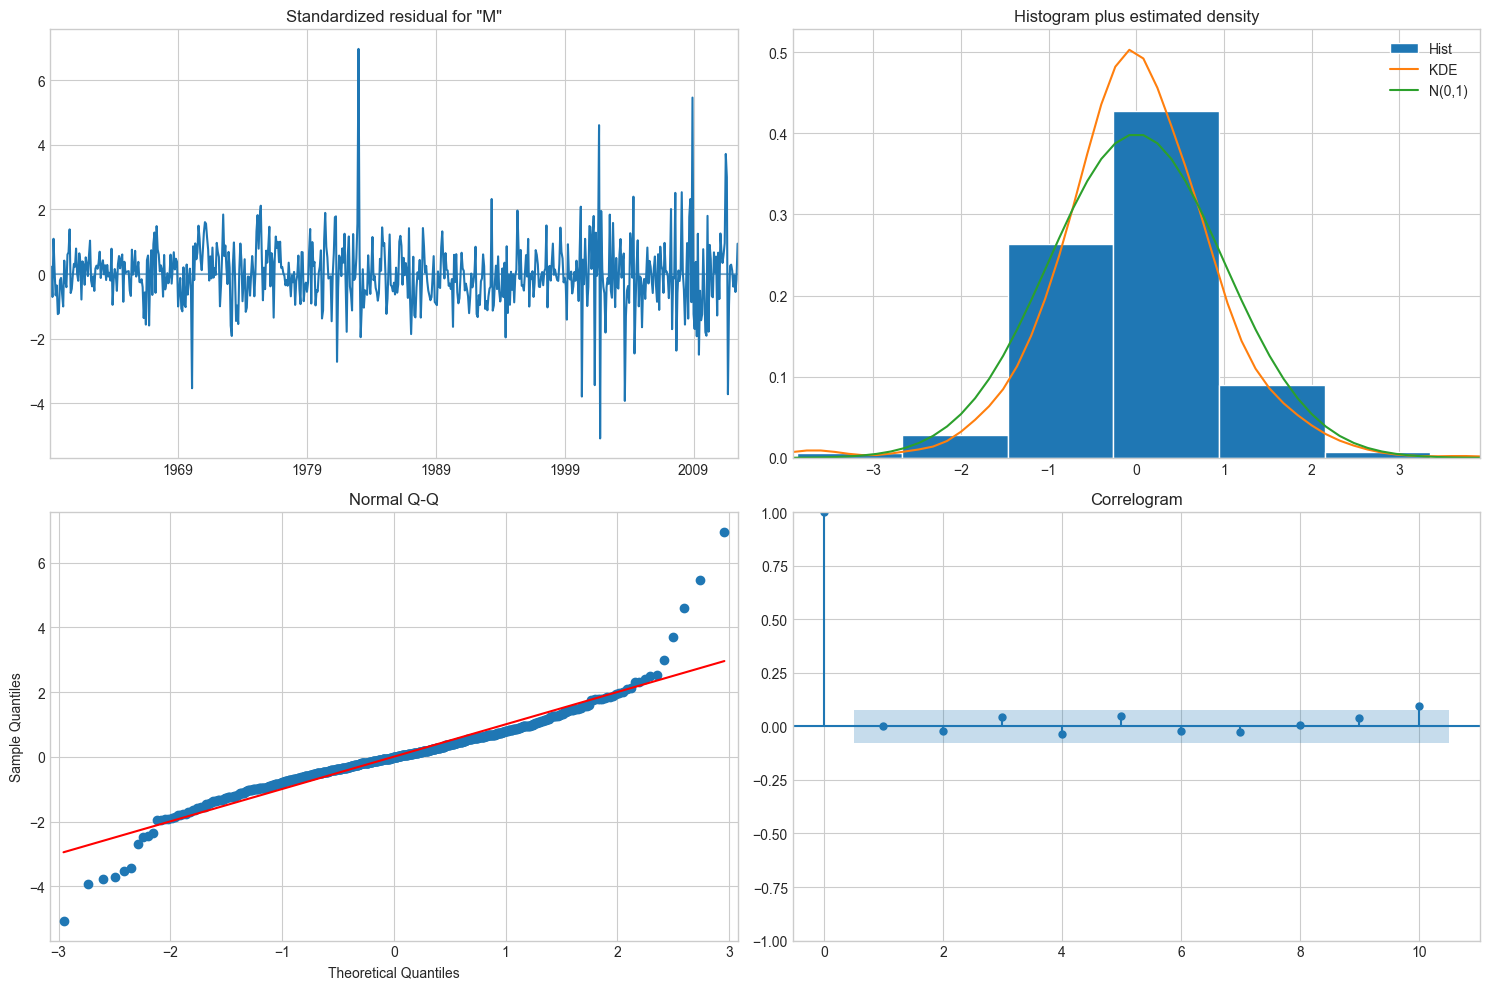


DIAGNOSTICS INTERPRETATION:
1. Standardized Residuals: Should fluctuate around 0 without clear patterns.
2. Histogram/KDE: Should look like a Normal Distribution (Green curve matches Orange).
3. Normal Q-Q: Dots should fall on the red line.
4. Correlogram (ACF): No bars should go outside the blue shaded area (implies no leftover correlation).


In [8]:
# Summary of the Best Model
print(best_model.summary())

# Plot Diagnostics
fig = best_model.plot_diagnostics(figsize=(15, 10))
plt.tight_layout()
plt.show()

# Interpretation printed for your reference
print("\nDIAGNOSTICS INTERPRETATION:")
print("1. Standardized Residuals: Should fluctuate around 0 without clear patterns.")
print("2. Histogram/KDE: Should look like a Normal Distribution (Green curve matches Orange).")
print("3. Normal Q-Q: Dots should fall on the red line.")
print("4. Correlogram (ACF): No bars should go outside the blue shaded area (implies no leftover correlation).")

Starting Rolling Forecast (this may take a moment)...

Evaluation Results (1-step ahead):
RMSFE: 0.5442
MAE:   0.2697


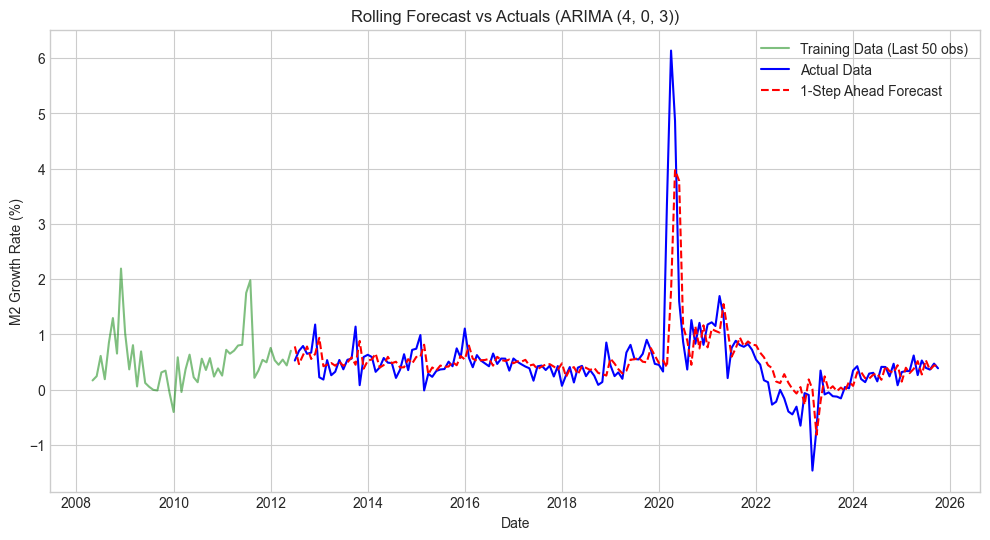

In [11]:
from sklearn.metrics import mean_squared_error

print("Starting Rolling Forecast (this may take a moment)...")

# 1. Initialize history with the training data
history = [x for x in train['M2_Growth']]
predictions = []
actuals = [x for x in test['M2_Growth']]

# 2. Rolling Forecast Loop
# We iterate over each time step in the test set.
# For each step:
#   a. Fit the ARIMA model using the current history (Train + previous Test data)
#   b. Forecast the next step (t+1)
#   c. Add the actual observed value to the history for the next iteration
for i in range(len(test)):
    # Re-estimate model with updated history using the best parameters found
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    
    # Forecast 1 step ahead
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    
    # Update history with the actual observation
    obs = actuals[i]
    history.append(obs)

# 3. Organize results in a DataFrame for comparison
forecast_df = pd.DataFrame({
    'Actual': test['M2_Growth'],
    'Forecast': predictions
}, index=test.index)

# 4. Calculate Evaluation Metrics
mse = mean_squared_error(test['M2_Growth'], predictions)
rmsfe = np.sqrt(mse)
mae = np.mean(np.abs(test['M2_Growth'] - predictions))

print(f"\nEvaluation Results (1-step ahead):")
print(f"RMSFE: {rmsfe:.4f}")
print(f"MAE:   {mae:.4f}")

# 5. Plotting Rolling Forecast vs Actuals
plt.figure(figsize=(12, 6))
# Zoom in on the last part of training data for better visibility
plt.plot(train.index[-50:], train['M2_Growth'][-50:], label='Training Data (Last 50 obs)', color='green', alpha=0.5)
plt.plot(test.index, test['M2_Growth'], label='Actual Data', color='blue')
plt.plot(test.index, forecast_df['Forecast'], label='1-Step Ahead Forecast', color='red', linestyle='--', linewidth=1.5)

plt.title(f'Rolling Forecast vs Actuals (ARIMA {best_order})')
plt.ylabel('M2 Growth Rate (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()